<a href="https://colab.research.google.com/github/vnaren13/cs666student/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

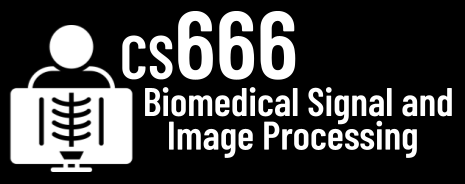
#Assignment 4

In [40]:
# NAME: VENKAT NAREN KOYA

In [41]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [42]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'indices', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [43]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [45]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [46]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [47]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [48]:
# TODO: Please display this image and print the dimensions!



image dimensions(1858, 2090)


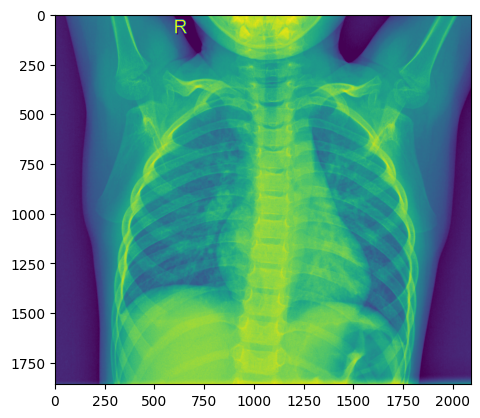

In [49]:
# TODO: YOUR CODE
imshow(img)
dimensions=img.shape
print("image dimensions"+str(dimensions))

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [50]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [51]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) The code reads image files from normal,pneumonia and covid directories.
# TODO: Operation 2) The code uses imresize() function to resize the loaded images to 300 X 300 and rgb2gray() function to convert RGB images to grayscale.
# TODO: Operation 3) The last line of code copies the values of loaded_image into a specific location in the data.

In [52]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

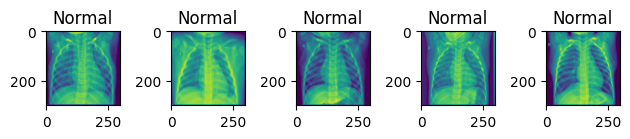

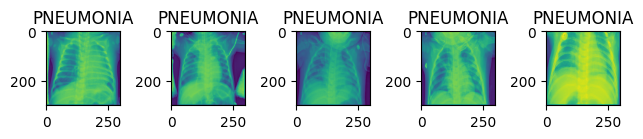

In [53]:
# TODO: YOUR CODE

for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.title("Normal")
  plt.imshow(data[0][i])  
plt.tight_layout()
plt.show()


for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title("PNEUMONIA")
    plt.imshow(data[1][i]) 
plt.tight_layout()
plt.show()



**Task 3:** Setup training and testing data. [15 Points]

In [54]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [55]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [56]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

y_train = np.concatenate((np.zeros(60), np.ones(60), np.full(60, 2)))


In [57]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [58]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.concatenate((np.zeros(40), np.ones(40), np.full(40, 2)))

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [59]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [60]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [61]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [62]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [63]:
# TODO: YOUR ANSWER
# Random Forest is a type of machine learning algorithm that uses a collection of decision trees to make predictions.
# It's commonly used for tasks like classification and regression, and is known for its accuracy and ability to handle complex data.

In [64]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [65]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [66]:
# TODO: YOUR ANSWER
# The classification accuracy is probably the best we can get. 
# Yes i am suprised with the fact that even though we sliced the directories without utilizing the total number images
# and even after performing certain data wrangling operations we were able to obtain that accuracy.

**Bonus:** Let's take a closer look! [33 Points]

In [67]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [68]:
# TODO: YOUR CODE AND YOUR ANSWER
covid_file = os.listdir(COVID_DIR)
images_used=TRAINING_COUNT+TESTING_COUNT
image_count=len(covid_file)-images_used
X_train_covid = np.zeros( (image_count, 300*300 ), dtype=np.float32)
t_pos_covid=0
for i in data[2][images_used:len(covid_file)]:
    i = i.ravel() # flatten the image
    i /= i.max() # normalize the image
    X_train_covid[t_pos_covid] = i
    t_pos_covid += 1

Y_train_covid = np.full(image_count, 2)
clf.score(X_train_covid, Y_train_covid)


0.9696969696969697

In [69]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

In [70]:
predictions=clf.predict(X_train_covid)
predictions

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [71]:
indices = np.where(predictions == 1)[0]
indices
  

array([15, 27, 84])

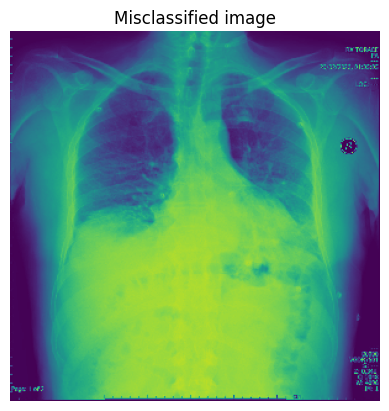

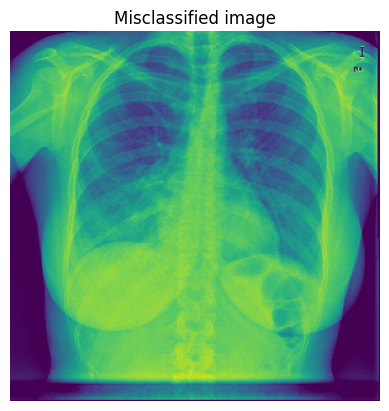

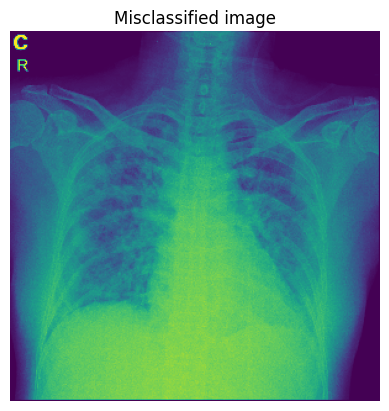

In [72]:
plt.title('misclassified images')
for i in indices:
  image_data = X_train_covid[i].reshape(300, 300)
  plt.imshow(image_data) 
  plt.axis('off')
  plt.title('Misclassified image')
  plt.show()


In [73]:
# references
# 1) https://stackoverflow.com/questions/48435229/how-to-plot-a-list-of-image-in-loop-using-matplotlib
# 2) https://towardsdatascience.com/understanding-random-forest-58381e0602d2

#collaboration
# Poornendu pabbati

In [74]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw